In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import csv
import pandas as pd
import io
import os
import cv2
from pandas.errors import EmptyDataError
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, BatchNormalization, Input 
from sklearn.model_selection import train_test_split
#from keras.layers.convolutional import Convolution2D, MaxPooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
import time

In [2]:
#Import data
dataset = pd.read_csv('Dataset/trainLabels.csv',on_bad_lines='skip')
image_folder_path = "Dataset/Images"

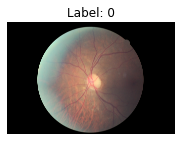

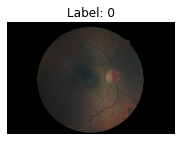

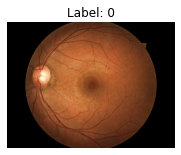

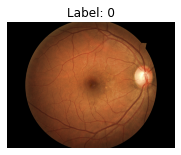

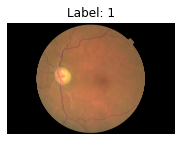

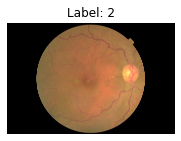

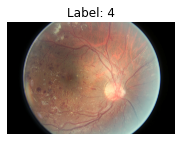

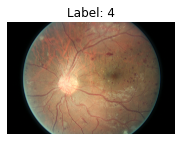

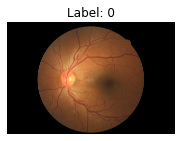

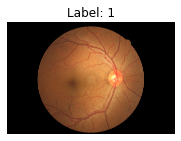

In [3]:
from PIL import Image
import os
count = 0
for index, row in dataset.iterrows():
    label = row['level']
    # Construct the full path to the image file
    image_path = os.path.join(image_folder_path, row['image']+'.jpeg')

    # Open and display the image
    image = Image.open(image_path)
    plt.figure(figsize=(3, 3))
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()
    if count>=9:
        break
    else:
        count=count+1

In [4]:
#Convert labels to one-hot-encoded format represent categorical data as numerical vectors.
one_hot_labels = pd.Series(dataset['level'])
one_hot_labels = pd.get_dummies(one_hot_labels, sparse = True)
one_hot_labels = np.asarray(one_hot_labels)

In [5]:
one_hot_labels

array([[ True, False, False, False, False],
       [ True, False, False, False, False],
       [ True, False, False, False, False],
       ...,
       [ True, False, False, False, False],
       [ True, False, False, False, False],
       [False,  True, False, False, False]])

In [6]:
x = []
y = []
fixed_size = (300, 300)

In [7]:
# resize them to a fixed size of (300, 300).
#  This fixed size is chosen to maintain retaining sufficient detail in the images for accurate classification.
for index, row in dataset.iterrows():
  image_path = os.path.join(image_folder_path, row['image']+'.jpeg')
  image = cv2.imread(image_path)
  if image is None:
    pass
  else: 
    resized_image = cv2.resize(image, fixed_size)
    x.append(resized_image)
    y.append(one_hot_labels[index])

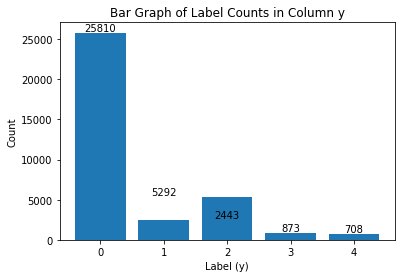

In [8]:
# Count the occurrences of each label in 'y'
label_counts = dataset['level'].value_counts().reset_index()
label_counts.columns = ['Label', 'Count']

# Sort the labels if needed
label_counts = label_counts.sort_values(by='Label')

# Create a bar graph
plt.bar(label_counts['Label'], label_counts['Count'])

# Add labels and title
plt.xlabel('Label (y)')
plt.ylabel('Count')
plt.title('Bar Graph of Label Counts in Column y')

# Add the height of each bar as text labels
for i, count in enumerate(label_counts['Count']):
    plt.text(label_counts['Label'][i], count, str(count), ha='center', va='bottom')

# Show the graph
plt.show()

In [9]:
X = x + x
Y = y + y
del x
del y
del one_hot_labels

In [10]:
# Split the dataset into training and validation sets into 80:20
x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size = 0.25, train_size = 0.75, random_state=42)

In [11]:
pretrained_model = tf.keras.applications.ResNet50(
    input_shape=(300, 300, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

In [12]:
pretrained_model.trainable = False
inputs = pretrained_model.input

conv1 = Conv2D(32, kernel_size=4, activation='relu')(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, kernel_size=4, activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, kernel_size=4, activation='relu')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(64, kernel_size=4, activation='relu')(pool3)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(32, kernel_size=4, activation='relu')(pool4)
pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

flat = Flatten()(pool5)

hidden1 = Dense(128, activation='relu')(flat)
hidden2 = Dense(128, activation='relu')(hidden1)
hidden3 = Dense(64, activation='relu')(hidden2)
outputs = Dense(5, activation='softmax')(hidden3)

In [13]:
#Build a custom model on top of the pre-trained ResNet50 model with Conv2D, MaxPooling2D,  Dense, Flatten, and BatchNormalization layers.
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)


In [14]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)

#Compile the model with 'adam' optimizer, 'categorical_crossentropy' loss function, and 'accuracy' metric.
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy']) 

In [15]:
y_train_raw = np.asarray(y_train).astype(np.float32)
x_train_raw = np.asarray(x_train).astype(np.float32)
x_valid_raw = np.asarray(x_valid).astype(np.float32)
y_valid_raw = np.asarray(y_valid).astype(np.float32)


In [16]:
start_time = time.time()
history = model.fit(
    x_train_raw, 
    y_train_raw,
    validation_data = (x_valid_raw, y_valid_raw),
    batch_size = 32,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_loss',
            patience = 15,
            restore_best_weights = True
        )
    ]
)
end_time = time.time()
training_time = end_time - start_time
print("Training time: {:.2f} seconds".format(training_time))     

Epoch 1/20
24/24 [==============================] - 421s 18s/step - loss: 0.9327 - accuracy: 0.7133 - val_loss: 0.8986 - val_accuracy: 0.6920
Epoch 2/20
24/24 [==============================] - 427s 18s/step - loss: 0.8179 - accuracy: 0.7360 - val_loss: 0.8573 - val_accuracy: 0.6920
Epoch 3/20
24/24 [==============================] - 369s 16s/step - loss: 0.7642 - accuracy: 0.7547 - val_loss: 0.7854 - val_accuracy: 0.7080
Epoch 4/20
24/24 [==============================] - 413s 18s/step - loss: 0.6840 - accuracy: 0.7573 - val_loss: 0.7602 - val_accuracy: 0.7240
Epoch 5/20
24/24 [==============================] - 422s 18s/step - loss: 0.6441 - accuracy: 0.7827 - val_loss: 0.7690 - val_accuracy: 0.7120
Epoch 6/20
24/24 [==============================] - 430s 18s/step - loss: 0.6116 - accuracy: 0.7853 - val_loss: 0.7471 - val_accuracy: 0.7200
Epoch 7/20
24/24 [==============================] - 430s 18s/step - loss: 0.5040 - accuracy: 0.8280 - val_loss: 0.6845 - val_accuracy: 0.7640
Epoch 

In [17]:
# Evaluate the Model on the validation data and print the test loss, test accuracy, and final validation accuracy.
score = model.evaluate(x_valid_raw, y_valid_raw, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
final_val_acc_tf = history.history['val_accuracy'][-1]
print("Final validation accuracy for TensorFlow: {:.4f}".format(final_val_acc_tf))     
# Save the TensorFlow model
model.save('tensorflow_model.h5')

Test loss: 0.6904615759849548
Test accuracy: 0.8320000171661377
Final validation accuracy for TensorFlow: 0.8320


C:\Users\amuly\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [19]:
# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

In [20]:
# Get number of epochs
epochs = range(len(acc))

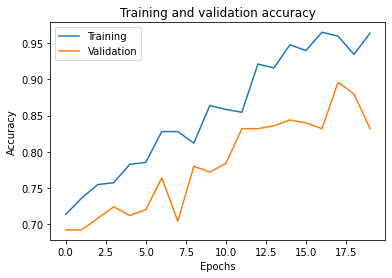

In [21]:
# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = 'Training')
plt.plot(epochs, val_acc, label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and validation accuracy')
plt.show()

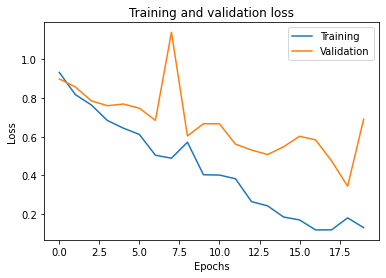

In [22]:
# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = 'Training')
plt.plot(epochs, val_loss, label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and validation loss')
plt.show()

In [23]:
predictions = model.predict(x_valid_raw)

8/8 [==============================] - 86s 10s/step


In [24]:
class_labels = np.argmax(predictions, axis=1)

In [25]:
actual_class_labels = np.argmax(y_valid, axis=1)

In [26]:
for i, prediction in enumerate(predictions):
    print(f"Image {i + 1} - Predicted Probabilities: {prediction}")
    print(f"Predicted Class: {class_labels[i]}")

Image 1 - Predicted Probabilities: [9.9751931e-01 2.1414387e-03 3.3337003e-04 1.5020147e-06 4.3544546e-06]
Predicted Class: 0
Image 2 - Predicted Probabilities: [9.9939764e-01 5.4377021e-04 5.7992915e-05 4.9924978e-07 9.8358846e-08]
Predicted Class: 0
Image 3 - Predicted Probabilities: [9.9216264e-01 2.0403569e-03 5.7907607e-03 2.3880134e-06 3.9591800e-06]
Predicted Class: 0
Image 4 - Predicted Probabilities: [3.7172809e-01 6.2328690e-01 4.8794122e-03 1.0301864e-04 2.5755260e-06]
Predicted Class: 1
Image 5 - Predicted Probabilities: [5.5570830e-02 1.3510705e-06 1.9283808e-04 4.3883090e-05 9.4419110e-01]
Predicted Class: 4
Image 6 - Predicted Probabilities: [0.663936   0.0434139  0.23009385 0.04998661 0.01256964]
Predicted Class: 0
Image 7 - Predicted Probabilities: [9.8374546e-01 1.6145758e-02 1.0778508e-04 8.8771395e-07 9.8998164e-08]
Predicted Class: 0
Image 8 - Predicted Probabilities: [9.9999094e-01 7.1957325e-06 7.4912703e-07 4.6936970e-09 1.1434159e-06]
Predicted Class: 0
Image 9

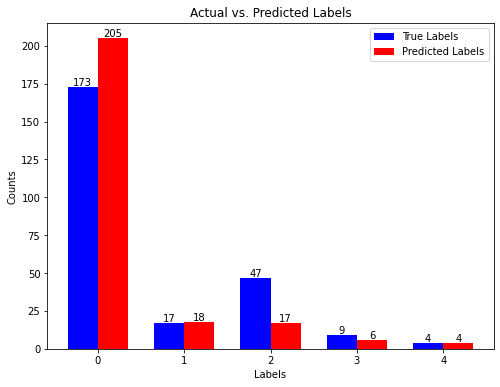

In [27]:

# Determine the range of label values
labels_range = range(max(max(actual_class_labels), max(class_labels)) + 1)

# Count the occurrences of each label in actual and predicted values using bincount
actual_counts = np.bincount(actual_class_labels, minlength=len(labels_range))
predicted_counts = np.bincount(class_labels, minlength=len(labels_range))

# Create a bar chart with different colors for true and predicted values
width = 0.35
x = np.arange(len(labels_range))
fig, ax = plt.subplots(figsize=(8, 6))

bar1 = ax.bar(x - width/2, actual_counts, width, label='True Labels', color='b')
bar2 = ax.bar(x + width/2, predicted_counts, width, label='Predicted Labels', color='r')

# Add actual counts on top of the bars
for i in range(len(labels_range)):
    ax.annotate(f'{actual_counts[i]}', (x[i] - width/2, actual_counts[i] + 1), ha='center')
    ax.annotate(f'{predicted_counts[i]}', (x[i] + width/2, predicted_counts[i] + 1), ha='center')

# Add labels, title, and legend
ax.set_xlabel('Labels')
ax.set_ylabel('Counts')
ax.set_title('Actual vs. Predicted Labels')
ax.set_xticks(x)
ax.set_xticklabels(labels_range)
ax.legend()

# Show the bar chart
plt.show()


In [28]:
data = {'Actual Labels': actual_class_labels, 'Predicted Labels': class_labels}
df = pd.DataFrame(data)
df

,Actual Labels,Predicted Labels
0,0,0
1,0,0
2,2,0
3,0,1
4,4,4
...,...,...
245,0,0
246,0,0
247,2,0
248,3,1


In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

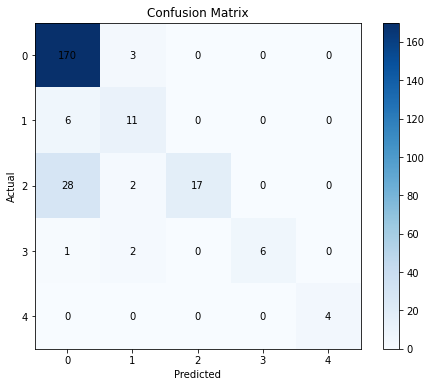

In [30]:
# Compute the confusion matrix with dynamic class labels extraction
cm = confusion_matrix(actual_class_labels, class_labels)

# Extract unique class labels from the data
unique_labels = np.unique(np.concatenate((actual_class_labels, class_labels)))

# Display the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(unique_labels))
plt.xticks(tick_marks, unique_labels)
plt.yticks(tick_marks, unique_labels)

plt.xlabel('Predicted')
plt.ylabel('Actual')

for i in range(len(unique_labels)):
    for j in range(len(unique_labels)):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='black')

plt.show()
